In [1]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt
from addict import Dict as Adict
import optuna
from deeptime.data import sqrt_model
from celerity.models import VAMPnetEstimator, HedgeVAMPNetEstimator
from functools import partial


from deeptime.util.data import TrajectoryDataset
from deeptime.util.torch import MLP
from deeptime.decomposition.deep import VAMPNet
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from deeptime.decomposition.deep import vampnet_loss


In [14]:
def define_batch_mod(trial, input_dim, output_dim, lag_time, n_epochs): 
    nn_config = Adict(
        hidden_layer_width=None, 
        input_dim=input_dim, 
        output_dim=output_dim,
        n_hidden_layers=None,
        lag_time = lag_time, 
        lr = None, 
        n_epochs = n_epochs,
        
        optimizer=torch.optim.Adam, 
        score = Adict(
              method='VAMP2', 
              mode='regularize', 
              epsilon=1e-6
        ), 
        loss = vampnet_loss, 
        device="cpu"
    ) 
    
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    hidden_layer_width = trial.suggest_int("width", 2, 50)
    n_hidden_layers = trial.suggest_int("depth", 1, 10)
    
    nn_config.hidden_layer_width = hidden_layer_width
    nn_config.lr = learning_rate
    nn_config.n_hidden_layers = n_hidden_layers
    
    return nn_config
    
    
def define_online_mod(trial, input_dim, output_dim, lag_time): 
    nn_config = Adict(
        hidden_layer_width=None, 
        input_dim=input_dim, 
        output_dim=output_dim,
        n_hidden_layers=None,
        loss = partial(vampnet_loss, method='VAMP2', mode='regularize', epsilon=1e-6 ), 
        device="cpu", 
        b=None, 
        n=None,
        s=1e-8
    ) 
    
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    hidden_layer_width = trial.suggest_int("width", 2, 50)
    n_hidden_layers = 10 # trial.suggest_int("depth", 1, 10)
    expert_learning_rate = trial.suggest_float("export_learning_rate", 0.5, 1-1e-8)

    nn_config.hidden_layer_width = hidden_layer_width
    nn_config.n = learning_rate
    nn_config.n_hidden_layers = n_hidden_layers
    nn_config.b = expert_learning_rate
    
    return nn_config


def fit_online(est, loader, n_epochs): 
    est.train()
    for i in range(n_epochs): 
        for batch in loader: 
            est.partial_fit(batch)
    return est

    
def eval_online(est, loader): 
    est.eval()
    tmp = []
    for val in loader: 
        tmp.append(-est.predict(val))    
    return np.mean(tmp)

    
def _objective(trial, data, mod_type): 
    OUTPUT_DIM = 1
    N_EPOCHS=1
    LAG_TIME=1
    INPUT_DIM=2
    VAL_FRAC=0.3
    N_BOOT=50
    
    
    # batch_size_power = trial.suggest_int("batch_size_power", 6, 11)
    batch_size = 2**7 # int(2**batch_size_power)
    
    dataset = TrajectoryDataset(LAG_TIME, data.astype(np.float32))
    n_val = int(len(dataset)*VAL_FRAC)

    scores = []
    if mod_type == 'batch':
        nn_config = define_batch_mod(trial, INPUT_DIM, OUTPUT_DIM, LAG_TIME, N_EPOCHS)        
    elif mod_type == 'online': 
        nn_config = define_online_mod(trial, INPUT_DIM, OUTPUT_DIM, LAG_TIME)    
    else: 
        raise NotImplementedError('model type not recognised')
        
    train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
    
    for _ in range(N_BOOT):
        sampler = torch.utils.data.RandomSampler(train_data, replacement=True)
        loader_train = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

        loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
    
        if mod_type == 'batch':
            est = VAMPnetEstimator(nn_config)
            est.fit(loader_train, loader_val)
            last_step = int(len(loader_train)*N_EPOCHS)
            
            score = est.dict_scores['validate']['VAMP2'][last_step]
            
        elif mod_type == 'online': 
            
            est = HedgeVAMPNetEstimator(**nn_config)
            est = fit_online(est, loader_train, N_EPOCHS)
            score = eval_online(est, loader_val)
            
        else: 
            raise NotImplementedError('model type not recognised')

        scores.append(score)
    return np.median(scores)


In [15]:
dtraj, traj = sqrt_model(n_samples=10000)

In [16]:
np.unique(dtraj, return_counts=True)

(array([0, 1], dtype=int32), array([5039, 4961]))

In [17]:
n_trials = 100

# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
db_name = "sqrt"
model_type = 'online'
storage_name = "sqlite:///{}.db".format(db_name)


sampler = optuna.samplers.TPESampler(**optuna.samplers.TPESampler.hyperopt_parameters(), multivariate=False)
# sampler = optuna.samplers.RandomSampler()


study = optuna.create_study(study_name=model_type+'_vv_small_expert_min_full_width', 
                            sampler=sampler, 
                            storage=storage_name, 
                            direction='maximize', 
                            load_if_exists=True)


objective = partial(_objective, data=traj, mod_type=model_type)

study.optimize(objective, n_trials=n_trials)



[I 2022-09-26 14:55:55,412] A new study created in RDB with name: online_vv_small_expert_min_full_width
[I 2022-09-26 14:56:38,247] Trial 0 finished with value: 1.2237231135368347 and parameters: {'learning_rate': 0.00048084976893622474, 'width': 24, 'export_learning_rate': 0.7590280407338668}. Best is trial 0 with value: 1.2237231135368347.
[I 2022-09-26 14:57:32,200] Trial 1 finished with value: 1.0132157802581787 and parameters: {'learning_rate': 1.541057208359026e-05, 'width': 43, 'export_learning_rate': 0.9798949685346768}. Best is trial 0 with value: 1.2237231135368347.
[I 2022-09-26 14:58:31,022] Trial 2 finished with value: 1.496133029460907 and parameters: {'learning_rate': 0.05317471186826257, 'width': 50, 'export_learning_rate': 0.8493689657612927}. Best is trial 2 with value: 1.496133029460907.
[I 2022-09-26 14:59:07,306] Trial 3 finished with value: 1.1796040534973145 and parameters: {'learning_rate': 0.008687827979818093, 'width': 5, 'export_learning_rate': 0.917097513870

In [18]:
study.trials_dataframe().to_hdf(f'{db_name}.h5', key=model_type)

In [19]:
df = study.trials_dataframe()

In [20]:
df.head()

,number,value,datetime_start,datetime_complete,duration,params_export_learning_rate,params_learning_rate,params_width,state
0,0,1.223723,2022-09-26 14:55:55.435832,2022-09-26 14:56:38.234076,0 days 00:00:42.798244,0.759028,0.000481,24,COMPLETE
1,1,1.013216,2022-09-26 14:56:38.255552,2022-09-26 14:57:32.186321,0 days 00:00:53.930769,0.979895,0.000015,43,COMPLETE
2,2,1.496133,2022-09-26 14:57:32.207617,2022-09-26 14:58:31.006611,0 days 00:00:58.798994,0.849369,0.053175,50,COMPLETE
3,3,1.179604,2022-09-26 14:58:31.029575,2022-09-26 14:59:07.285457,0 days 00:00:36.255882,0.917098,0.008688,5,COMPLETE
4,4,1.507143,2022-09-26 14:59:07.311597,2022-09-26 15:00:03.222944,0 days 00:00:55.911347,0.714740,0.000333,46,COMPLETE


(0.0, 2.0)

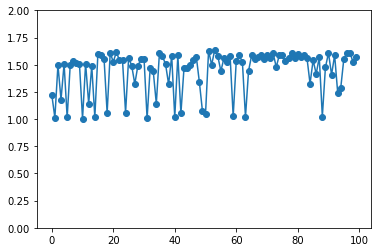

In [21]:
plt.plot(df['value'], marker='o')
plt.ylim(0, 2)